<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/conv_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display

In [2]:
#!pip install wandb

In [3]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [4]:
%matplotlib inline

In [4]:
cifar_means = (0.49139968, 0.48215827, 0.44653124)
cifar_stds = (0.24703233, 0.24348505, 0.26158768)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_means, cifar_stds)])

In [6]:
BATCH_TRAIN = 10
BATCH_TEST = 100
WRKRS = 2
TOWHERE = './data'
SEED = 42
EPOCHS = 3
LR = 1e-4

In [7]:
trainset = datasets.CIFAR10(root = TOWHERE, train=True, download=True, transform = transform)
testset = datasets.CIFAR10(root = TOWHERE, train=False, download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_TRAIN, num_workers = WRKRS, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_TEST, num_workers = WRKRS, pin_memory = True, shuffle = False)

100%|██████████| 170498071/170498071 [00:02<00:00, 80648418.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [10]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEDD'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.determetistic = True

seed_all(SEED)

In [12]:
class MyCIFAR(nn.Module):
  def __init__(self):
    super(MyCIFAR, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def convolute(self, conv, x):
    convd = conv(x)
    activated = F.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


  def forward(self, x):
    x = self.convolute(self.conv1, x)
    x = self.convolute(self.conv2, x)
    x = self.flatten(x)
    x = self.fcs(x)
    return x


In [13]:
net = MyCIFAR()
optimizer = optim.Adam(net.parameters(), lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [14]:
def train(net, optimizer, loss_fn, normalize=False):
  curloss = 0.0
  for epoch in range(EPOCHS):
    for i, batch in enumerate(tqdm_notebook(train_loader)):
      optimizer.zero_grad()
      X, y = batch
      y_pred = net(X)
      if normalize:
        y_pred = F.softmax(y_pred, dim=1)
        loss = loss_fn(y_pred, y)

        l2reg = torch.tensor(0.)
        for p in net.parameters():
          l2reg+=torch.norm(p, p=2)
        loss+=0.001*l2reg
      else:
        loss = loss_fn(y_pred, y)

      loss.backward()
      optimizer.step()
      curloss += loss.item()

      if not (i % int(train_loader.dataset.data.shape[0] / BATCH_TRAIN / 10)):
        print(f'Epoch: {epoch+1}, loss: {round(curloss, 3)}')
        curloss = 0.0

train(net, optim.Adam(net.parameters(), lr=LR, weight_decay=0.001), nn.CrossEntropyLoss(), normalize=True)

<ipython-input-14-6858581ef8a9>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1, loss: 2.32
Epoch: 1, loss: 1147.251
Epoch: 1, loss: 1109.091
Epoch: 1, loss: 1098.14
Epoch: 1, loss: 1087.972
Epoch: 1, loss: 1086.431
Epoch: 1, loss: 1086.484
Epoch: 1, loss: 1082.588
Epoch: 1, loss: 1078.318
Epoch: 1, loss: 1074.906


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2, loss: 1070.418
Epoch: 2, loss: 1069.771
Epoch: 2, loss: 1065.76
Epoch: 2, loss: 1066.419
Epoch: 2, loss: 1066.207
Epoch: 2, loss: 1061.329
Epoch: 2, loss: 1061.741
Epoch: 2, loss: 1058.786
Epoch: 2, loss: 1064.441
Epoch: 2, loss: 1055.122


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3, loss: 1058.001
Epoch: 3, loss: 1056.808
Epoch: 3, loss: 1055.34
Epoch: 3, loss: 1052.982
Epoch: 3, loss: 1047.848
Epoch: 3, loss: 1051.249
Epoch: 3, loss: 1049.935
Epoch: 3, loss: 1051.779
Epoch: 3, loss: 1048.661
Epoch: 3, loss: 1043.433


In [18]:
class_correct = [0]*10
class_total = [0]*10

In [19]:
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred,1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print(f'Accuracy: {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy: plane: 61.4%
Accuracy: car: 50.0%
Accuracy: bird: 15.7%
Accuracy: cat: 17.8%
Accuracy: deer: 31.8%
Accuracy: dog: 22.7%
Accuracy: frog: 67.5%
Accuracy: horse: 52.3%
Accuracy: ship: 0.0%
Accuracy: truck: 64.5%


### Conditions: baseline\custom\logitnorm

> Batchsize:4\10\10

> Start loss: ~900\1100\1150

> End loss: ~400\760\1040


>>Accuracy: plane: 51.6% \ 62.1% \ 61.4%

>>Accuracy: car: 63.7% \ 56.1%  \ 50%

>>Accuracy: bird: 34.6% \ 44.2% \ 15.7%

>>Accuracy: cat: 53.8% \ 23.4% \ 17.8%

>>Accuracy: deer: 42.4% \ 37.5% \ 31.8%

>>Accuracy: dog: 0.0% \ 45.2% \ 22.7%

>>Accuracy: frog: 74.2% \ 71.9% \ 67.5%

>>Accuracy: horse: 66.9% \61.1% \ 52.3%

>>Accuracy: ship: 69.3% \ 0.0% \ 0.0%

>>Accuracy: truck: 55.8% \ 66.5% \ 64.5%


On this particular model looks like smaller batchsize (4) works better compared to larger (10). Also we've tested Alpha's logitnorm (used to fight overfitting) but in our case it worked worse even though it had been stated that l2 regularization and normalization of y_pred before putting it into loss function won't worsen the result.

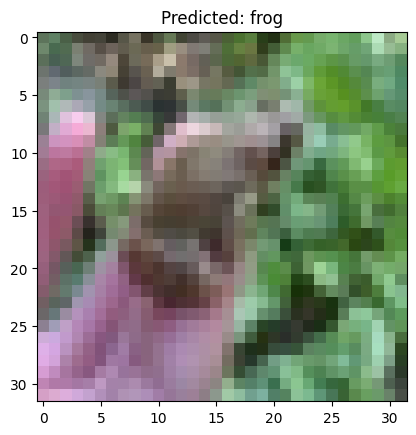

In [23]:
def visualize_result(idx):
    img = test_loader.dataset.data[idx]
    plt.imshow(img)
    
    image = transform(img)  
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(np.random.randint(low=0, high=10000))

In [17]:
class AnotherConv(nn.Module):
  def __init__(self):
    super(AnotherConv, self).__init__()

    self.pool = nn.MaxPoll2D(kernel=2, stride=2)
    self.flatten = nn.Flatten()

    self.conv1 = nn.Conv2D(in_channels=3, out_channels=6, kernel = 5)
    self.conv2 = nn.Conv2D(in_channels=6, out_channels=16, kernel = 5)
    self.conv3 = nn.Conv2D(in_channels=16, out_channels=32, kernel = 5)

    self.fc1 = nn.Linear(288, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(self.conv3(F.relu(self.conv2(x))))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Lets count the size for inputs one more time

1. Input image has 3 channels $32*32 = 32*32*3 =3072$ so the size is 3072
2. We retain the channels and calculate output size for **Width** and **Height** for first convolutions that is $Width^{out} = \frac{32-5 + 2*0}{1}+1 =28$ and $Height^{out} = \frac{32-5 + 2*0}{1}+1 =28$ 
3. We specified that or **out_channels=6** and **filter=5** so we've applied **six 5x5** filters to the image and resulted in **6(channels) * 28(width) * 28(height)** output
4. Apply max pooling stride=2 kernel=2 which lowers the dimensions to **6x14x14=1176**
5. For next convolution the out_channels=16 kernel=5 so for input 14x14 we take $Width^{out}=\frac{14-5+2*0}{1}+1=10$ and $Height^{out}=\frac{14-5+2*0}{1}+1=10$
6. The output is **16x10x10**
7. We dont do the pooling here and go straight to conv3
8. Third convolution makes **out_channels=32, kernel=5 for 10x10** input we get $Width^{out}=\frac{10-5+2*0}{1}+1=6$ and $Height^{out}=\frac{10-5+2*0}{1}+1=6$
9. And the output is **32x6x6**
10. Max pooling for stride=2 filter=2 makes it **32x3x3=288**
11. We perform the flattening which makes it **(288,)**
12. And the input size on the first fully-connected layer is **288** in our case
13. **288 -> 120 -> 84 -> 10** classes on output